In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------------------------
# Configuration / Parameters
# ---------------------------
ARMS = ["Top Banner", "Sidebar", "Footer", "Pop-up"]
# True CTRs (unknown to the algorithm). Change these to simulate different scenarios.
TRUE_CTRS = [0.05, 0.08, 0.02, 0.10]

EPSILON = 0.1           # exploration probability (10%)
N_IMPRESSIONS = 1000    # number of impressions per run
SEED = None             # set to an int for reproducible runs, or None

OUTPUT_DIR = "mab_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
# ---------------------------
# Epsilon-Greedy implementation
# ---------------------------
def run_epsilon_greedy(true_ctrs, epsilon=0.1, n_impressions=1000, seed=None):
    """
    Run one epsilon-greedy simulation.

    Returns:
        summary_df: pandas.DataFrame with per-arm stats (times selected, estimated ctr, clicks)
        selection_history: list of selected arm indices (len = n_impressions)
        reward_history: list of rewards (0/1)
        cumulative_rewards: list of cumulative rewards over time
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    n_arms = len(true_ctrs)
    counts = [0] * n_arms            # times each arm selected
    values = [0.0] * n_arms          # estimated CTRs (running averages)
    selection_history = []
    reward_history = []
    cumulative_rewards = []

    total_reward = 0

    for t in range(1, n_impressions + 1):
        # Explore with prob epsilon, otherwise exploit
        if random.random() < epsilon:
            chosen = random.randrange(n_arms)
        else:
            max_val = max(values)
            # tie-breaking randomly among max-valued arms
            candidates = [i for i, v in enumerate(values) if v == max_val]
            chosen = random.choice(candidates)

        # simulate reward (click) according to true CTR
        reward = 1 if random.random() < true_ctrs[chosen] else 0

        # online update for estimated CTR (incremental average)
        counts[chosen] += 1
        values[chosen] += (reward - values[chosen]) / counts[chosen]

        selection_history.append(chosen)
        reward_history.append(reward)
        total_reward += reward
        cumulative_rewards.append(total_reward)

    # Build summary DataFrame
    total_clicks_per_arm = [0] * n_arms
    for idx, r in zip(selection_history, reward_history):
        total_clicks_per_arm[idx] += r

    summary_df = pd.DataFrame({
        "Arm": ARMS,
        "True_CTR": true_ctrs,
        "Times_Selected": counts,
        "Estimated_CTR": [round(v, 6) for v in values],
        "Clicks": total_clicks_per_arm,
        "Observed_CTR": [round(total_clicks_per_arm[i] / counts[i], 6) if counts[i] > 0 else 0.0 for i in range(n_arms)]
    })

    return summary_df, selection_history, reward_history, cumulative_rewards

In [5]:
# ---------------------------
# Plotting helpers
# ---------------------------
def plot_selection_counts(summary_df, output_path=None):
    plt.figure(figsize=(8, 4.5))
    plt.bar(summary_df["Arm"], summary_df["Times_Selected"])
    plt.title("Times Each Ad Slot Was Selected")
    plt.xlabel("Ad Slot")
    plt.ylabel("Times Selected")
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=150)
    plt.show()


def plot_cumulative_clicks(cumulative_rewards, output_path=None):
    plt.figure(figsize=(8, 4.5))
    plt.plot(range(1, len(cumulative_rewards) + 1), cumulative_rewards)
    plt.title("Cumulative Clicks Over Time")
    plt.xlabel("Impression Number")
    plt.ylabel("Cumulative Clicks")
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=150)
    plt.show()


def plot_selection_fractions(selection_history, n_arms, output_path=None):
    n = len(selection_history)
    running_counts = np.zeros((n, n_arms), dtype=int)
    for i, sel in enumerate(selection_history):
        if i == 0:
            running_counts[i, sel] = 1
        else:
            running_counts[i] = running_counts[i - 1]
            running_counts[i, sel] += 1
    running_fraction = running_counts / np.arange(1, n + 1).reshape(-1, 1)

    plt.figure(figsize=(10, 5))
    for i in range(n_arms):
        plt.plot(range(1, n + 1), running_fraction[:, i], label=ARMS[i])
    plt.title("Running Selection Fraction for Each Ad Slot")
    plt.xlabel("Impression Number")
    plt.ylabel("Fraction of Impressions Assigned")
    plt.legend()
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=150)
    plt.show()

Running Epsilon-Greedy Multi-Armed Bandit simulation
Arms: ['Top Banner', 'Sidebar', 'Footer', 'Pop-up']
True (hidden) CTRs: [0.05, 0.08, 0.02, 0.1]
Epsilon: 0.1, Impressions: 1000, Seed: None

Total impressions: 1000
Total clicks: 100

Per-arm summary:
       Arm  True_CTR  Times_Selected  Estimated_CTR  Clicks  Observed_CTR
Top Banner      0.05              32       0.031250       1      0.031250
   Sidebar      0.08              51       0.078431       4      0.078431
    Footer      0.02              16       0.000000       0      0.000000
    Pop-up      0.10             901       0.105438      95      0.105438

Saved summary CSV to: mab_results/mab_summary.csv


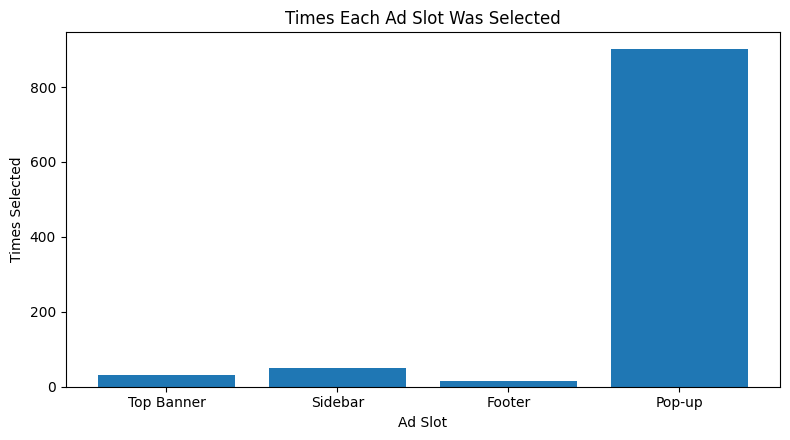

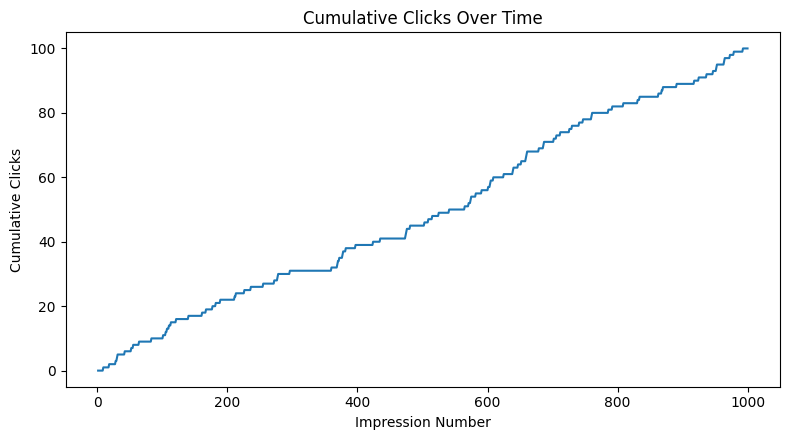

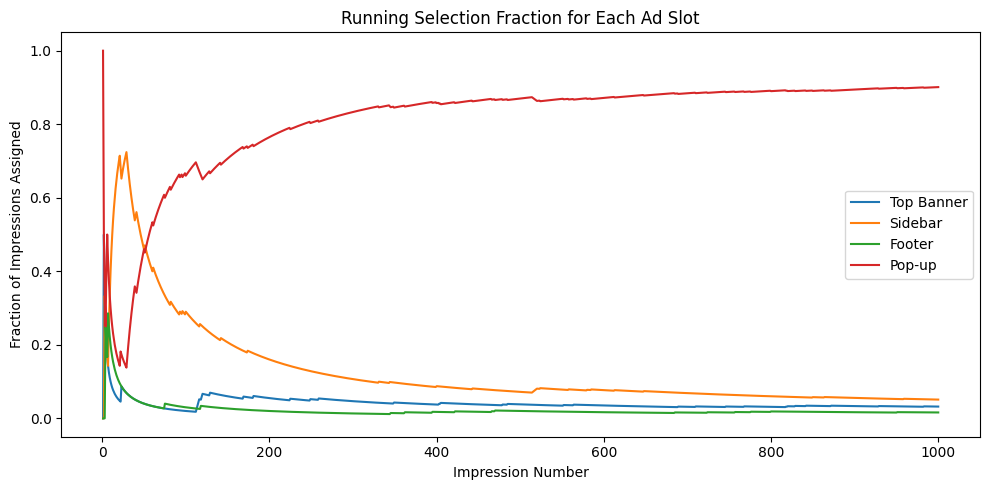

Plots saved in folder: mab_results
Done.


In [6]:
# ---------------------------
# Main script
# ---------------------------
def main():
    print("Running Epsilon-Greedy Multi-Armed Bandit simulation")
    print(f"Arms: {ARMS}")
    print(f"True (hidden) CTRs: {TRUE_CTRS}")
    print(f"Epsilon: {EPSILON}, Impressions: {N_IMPRESSIONS}, Seed: {SEED}\n")

    summary_df, selection_history, reward_history, cumulative_rewards = run_epsilon_greedy(
        TRUE_CTRS, epsilon=EPSILON, n_impressions=N_IMPRESSIONS, seed=SEED)

    total_clicks = sum(reward_history)
    print(f"Total impressions: {N_IMPRESSIONS}")
    print(f"Total clicks: {total_clicks}\n")

    print("Per-arm summary:")
    print(summary_df.to_string(index=False))

    # Save CSV
    csv_path = os.path.join(OUTPUT_DIR, "mab_summary.csv")
    summary_df.to_csv(csv_path, index=False)
    print(f"\nSaved summary CSV to: {csv_path}")

    # Save plots
    plot_selection_counts(summary_df, output_path=os.path.join(OUTPUT_DIR, "selection_counts.png"))
    plot_cumulative_clicks(cumulative_rewards, output_path=os.path.join(OUTPUT_DIR, "cumulative_clicks.png"))
    plot_selection_fractions(selection_history, len(ARMS), output_path=os.path.join(OUTPUT_DIR, "selection_fractions.png"))

    print(f"Plots saved in folder: {OUTPUT_DIR}")
    print("Done.")


if __name__ == "__main__":
    main()